In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import Perceptron
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import GridSearchCV

from sklearn.utils._testing import ignore_warnings
from sklearn.linear_model import SGDClassifier
from sklearn.exceptions import ConvergenceWarning,FitFailedWarning

from deslib.des.meta_des import METADES
from deslib.des.knora_u import KNORAU
from deslib.des.knora_e import KNORAE
from deslib.dcs.lca import LCA
from deslib.dcs.ola import OLA
from deslib.static.single_best import SingleBest
from deslib.static.static_selection import StaticSelection
from sklearn.model_selection import KFold

from sklearn.ensemble import BaggingClassifier


from sklearn.ensemble import RandomForestRegressor


import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
np.random.seed(888)

df = pd.read_csv('20210427-dados-gdcc.csv')

remove_cols = ['DayW']
df.drop(remove_cols, axis=1, inplace=True)

df['Macrocategory'] = df.Macrocategory.astype('category')


months = {1:'Jan', 2:'Feb',3:'Mar',4: 'Apr',5: 'May' ,6:'June',7: 'July',8: 'Aug',9: 'Sept',10:'Oct',11: 'Nov',12: 'Dec'}
df = df.replace({"Month": months})

df['Month'] = df.Month.astype('category')
df['Year'] = df.Year.astype('int')

df = pd.get_dummies(df, columns=["Macrocategory"])
df = pd.get_dummies(df, columns=["Month"])

print(df.columns)
#y = df.Success
#X = df.drop(labels=['Success'], axis=1)


def get_Best_Features(df):
    y = df.Success
    X = df.drop(labels=['Success', 'Year'], axis=1)
    ss = StandardScaler()
    X = pd.DataFrame(ss.fit_transform(X),columns = X.columns)
    model = RandomForestRegressor()
    model.fit(X,y)
    names = list(X)
    importances = model.feature_importances_
    
    features_score = []
    
    for i,v in enumerate(importances): 
        features_score.append([names[i],v])
    
    features_score.sort(key=lambda x: x[1],reverse=True)
    
    for f in features_score:
        print(f)
    
    
#get_Best_Features(df)

Index(['Year', 'Dom1', 'Seg2', 'Ter3', 'Qua4', 'Qui5', 'Sex6', 'Sab7',
       'LnGoal', 'LnPledges', 'Duration', 'Rewards', 'dArt', 'NSSj', 'NSSt',
       'GINI', 'Popold', 'Illiteracy', 'LnPopEstm2015', 'LnPIBpercap',
       'LnAreaKM', 'Success', 'Macrocategory_Arq_Urb', 'Macrocategory_Arte',
       'Macrocategory_C&T', 'Macrocategory_Carnaval',
       'Macrocategory_Cin_Video', 'Macrocategory_Circo',
       'Macrocategory_Comunidade', 'Macrocategory_Dança',
       'Macrocategory_Design', 'Macrocategory_Educação',
       'Macrocategory_Esporte', 'Macrocategory_Eventos',
       'Macrocategory_Fotografia', 'Macrocategory_Gastronomia',
       'Macrocategory_Jogos', 'Macrocategory_Jornalismo',
       'Macrocategory_Literatura', 'Macrocategory_Meio Ambiente',
       'Macrocategory_Mob_Transporte', 'Macrocategory_Moda',
       'Macrocategory_Música', 'Macrocategory_Negócios Sociais',
       'Macrocategory_Quadrinhos', 'Macrocategory_Teatro', 'Month_Apr',
       'Month_Aug', 'Month_Dec', 'M

In [4]:
def reescalar_dados(df):
    ss = StandardScaler()
    
    rotulos = df.columns
    
    cols = [col for col in df.columns if col not in ['Year','Success']]   
    df[cols] = StandardScaler().fit_transform(df[cols])    
    
    return df

#df = reescalar_dados(df)

Text(0, 0.5, 'Frequency')

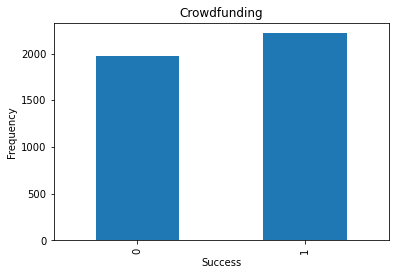

In [5]:
count_classes = pd.value_counts(df['Success'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Crowdfunding")
plt.xlabel("Success")
plt.ylabel("Frequency")

In [6]:
scenarios = [[2011], [2011,2012], [2011,2012,2013], [2011,2012,2013,2014]]

param_single = {}

param_static_s = {'pct_classifiers':[0.25,0.5,0.75,0.10]}


param_ola = {'k':[3,7, 5, 9, 13], 'DFP': [True, False], 'with_IH':[True, False],  'IH_rate':[0.01,0.1, 0.3, 0.6, 0.9], 'diff_thresh':[0.01,0.1,0.3,0.5]}


param_lca = {'k':[3,7, 5, 9, 13], 'DFP': [True, False], 'with_IH':[True, False],  'IH_rate':[0.01,0.1, 0.3, 0.6, 0.9], 'diff_thresh':[0.01,0.1,0.3,0.5]}


param_knorae = {'k':[3,7, 5, 9, 13], 'DFP': [True, False], 'with_IH':[True, False],  'IH_rate':[0.01,0.1, 0.3, 0.6, 0.9]}
  

param_knorau = {'k':[3,7, 5, 9, 13], 'DFP': [True, False], 'with_IH':[True, False],  'IH_rate':[0.01,0.1, 0.3, 0.6, 0.9]}
    
    
#[SGDClassifier(),param_sgd]


In [7]:
def return_model_by_name(model_name, pool, k,dfp, with_ih, ih_rate):
    if model_name == "METADES":
        return METADES(pool_classifiers=pool,k=k,DFP=dfp,with_IH=with_ih,IH_rate=ih_rate,random_state=888)
    if model_name == "KNORAU":
        return KNORAU(pool_classifiers=pool,k=k,DFP=dfp,with_IH=with_ih,IH_rate=ih_rate,random_state=888)
    if model_name == "KNORAE":
        return KNORAE(pool_classifiers=pool,k=k,DFP=dfp,with_IH=with_ih,IH_rate=ih_rate,random_state=888)
    if model_name == "OLA":
        return OLA(pool_classifiers=pool,k=k,DFP=dfp,with_IH=with_ih,IH_rate=ih_rate,random_state=888)
    if model_name == "LCA":
        return LCA(pool_classifiers=pool,k=k,DFP=dfp,with_IH=with_ih,IH_rate=ih_rate,random_state=888)
    if model_name == "SingleBest":
        return SingleBest(pool_classifiers=pool,random_state=888)
    if model_name == "StaticSelection":
        return StaticSelection(pool_classifiers=pool,random_state=888)
    
def cross_validation_model(X, y,cv, model_name,pool,k,dfp,with_ih,ih_rate):
    kf = KFold(n_splits=cv)
    accs = []
    rocs = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = return_model_by_name(model_name,pool,k,dfp,with_ih,ih_rate)
        model.fit(X_train,y_train)
        pred = model.predict(X_test) 
        accs.append(accuracy_score(y_test, pred))
        rocs.append(roc_auc_score(y_test, pred))
        
    acc = np.mean(accs)
    roc = np.mean(rocs)
    return acc, roc

def simple_gridSearch(model_name, pools, X_train, y_train):  
    
    best_acc = 0
    best_roc = 0
    best_k = 0
    best_dfp = 0
    best_with_ih = 0
    best_ih_rate = 0
    best_pool = None
    
    if(model_name != "SingleBest" and model_name != "StaticSelection"):  
        list_k = [3,7, 5, 9, 13]
        list_dfp = [True, False]
        list_with_ih = [True, False]
        list_ih_rate = [0.01,0.1, 0.3,0.4, 0.5]        
        
        for k in list_k:
            for dfp in list_dfp:
                for with_ih in list_with_ih:
                    for ih_rate in list_ih_rate:
                        for pool in pools:
                            acc, roc = cross_validation_model(X_train, y_train,3, model_name,pool,k,dfp,with_ih,ih_rate)
                            if(roc >= best_roc):
                                if(acc > best_acc):
                                    best_acc = acc
                                    best_roc = roc
                                    best_k = k
                                    best_dfp = dfp
                                    best_with_ih = with_ih
                                    best_ih_rate = ih_rate
                                    best_pool = pool
                            print(roc,acc)
                        
        return return_model_by_name(model_name, best_pool, best_k,best_dfp, best_with_ih, best_ih_rate)
    
    for pool in pools:
        acc, roc = cross_validation_model(X_train, y_train,3, model_name,pool,None,None,None,None) 
        if(roc >= best_roc):
            if(acc > best_acc):
                best_acc = acc
                best_roc = roc
                best_pool = pool
    return return_model_by_name(model_name, best_pool, None,None, None, None)
    
def scaler_set(df):
    ss = StandardScaler()
    df = pd.DataFrame(ss.fit_transform(df),columns = df.columns)

    return df




@ignore_warnings(category=(ConvergenceWarning,FitFailedWarning,UserWarning))
def fic():
    for i, scenario in enumerate(scenarios):
        
        print("SCENARIO:", i+1)            

        df_train = df.loc[df['Year'].isin(scenario)]
        df_test = df.loc[~df['Year'].isin(scenario)]        
        
        y_train = df_train.Success
        X_train = df_train.drop(labels=['Success', 'Year'], axis=1)
        X_train = scaler_set(X_train)        
        
        y_test = df_test.Success
        X_test = df_test.drop(labels=['Success', 'Year'], axis=1)
        X_test = scaler_set(X_test)
        
        
        pool_d = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=100)
        pool_d.fit(X_train, y_train)

        pool_p = BaggingClassifier(base_estimator=CalibratedClassifierCV(Perceptron()), n_estimators=100)
        pool_p.fit(X_train, y_train) 
                                   
        pools = [pool_d,pool_p ]                           

        param_meta = {'k':[3,7, 5, 9, 13], 'Kp':[5,3, 7,9], 'Hc':[1.0, 2.0, 0.5], 'mode':['selection', 'weighting ','hybrid'] }


        models = [[METADES(),param_meta],[KNORAU(), param_knorau],
                  [KNORAE(),param_knorae ], [OLA(),param_ola], 
                  [LCA(),param_lca], [SingleBest(),param_single], 
                  [StaticSelection(),param_static_s] ]


        for j,m in enumerate(models):

            #if j!=1:
            #    continue

            model = m[0]
            name = type(model).__name__
            print(name)

            #param = m[1]

            #print(model.get_params().keys())

            #clf = GridSearchCV(model, param, n_jobs=-1, cv=3)

            #clf.fit(X_train, y_train)       

            model = simple_gridSearch(name, pools, X_train, y_train) 
            model.fit(X_train, y_train)  
            print(model)

            pred = model.predict(X_test)
            y_pred_quant = model.predict_proba(X_test)[:, 1]
            #y_pred_quant = model.decision_function(X_test) SVM


            print("acc",accuracy_score(y_test, pred)*100)
            print("auc",roc_auc_score(y_test, y_pred_quant)*100)
            print("f1", f1_score(y_test, pred)*100)
            print("----------------------------------------")

        print("+++++++++++++++++++++++++++++++++++++++")    
    
          
fic()

SCENARIO: 1
METADES
0.93964720286846 0.9394949494949495
0.8926601859074529 0.8957575757575759
0.93964720286846 0.9394949494949495
0.8926601859074529 0.8957575757575759
0.93964720286846 0.9394949494949495
0.8926601859074529 0.8957575757575759
0.7837718242954518 0.7884511784511785
0.8023665061831581 0.812020202020202
0.7837718242954518 0.7884511784511785
0.8023665061831581 0.812020202020202
1.0 1.0
0.9181658182679241 0.9226599326599327
1.0 1.0
0.9181658182679241 0.9226599326599327
1.0 1.0
0.9181658182679241 0.9226599326599327
1.0 1.0
0.9181658182679241 0.9226599326599327
1.0 1.0
0.9181658182679241 0.9226599326599327
0.93964720286846 0.9394949494949495
0.9033743501941386 0.9058922558922559
0.93964720286846 0.9394949494949495
0.9033743501941386 0.9058922558922559
0.93964720286846 0.9394949494949495
0.9033743501941386 0.9058922558922559
0.7837718242954518 0.7884511784511785
0.8023665061831581 0.812020202020202
0.7837718242954518 0.7884511784511785
0.8023665061831581 0.812020202020202
1.0 1.

KeyboardInterrupt: 